# Machine Learning Inspired Wind Energy Forecast
### Andrew LaCroix
##### TDI Fellow, Spring 2019<br><br><br>

## Why this project?
#### 1) My background
After completing my PhD, I taught a course on *Engineering Design and Communication*, leading several teams to create engineering solutions for challenges related to climate change. As my teams were finishing up their prototypes and I was applying to The Data Incubator, I decided to pursue a design project of my own aimed at providing a data-driven solution to a computational challenge in climate change and renewable energy.

#### 2) Richness of data
Another motivating factor that led me to pursue this project was the opportunity to interact with complex, multi-variate data from several sources. Some of the most important discoveries I made during graduate school were derived from the combination of two (or more) distinct datasets or tools to answer a more complex, and more relevant question. This capstone project combines machine learning with two large, spatially-varying, and multivariate datasets. Together, they provide a new resource to help guide the growth of renewable energy technology.

#### 3) Drive growth in renewable energy technology
What is keeping us from achieving 100% renewable energy? In a word, *variability*. The amount of energy produced by renewable energy sources such as solar and wind varies significantly hour-by-hour, day-by-day. Since energy grids require a near perfect balance between energy generation and energy demand, other sources of power are needed when the sun doesn't shine or the wind doesn't blow. Currently, the variability in renewable energy sources is balanced by fossil fuels, which isn't ideal. However, it could be balanced by other renewables, most promisingly pumped hydroelectric stations. These stations act as giant batteries and can store excess energy when production exceeds demand or deliver energy on-demand. This technology presents us with both a business problem and a business opportunity, both of which can be solved by an accurate long-term forecast:
 - __PROBLEM:__ These stations need to know hours to days in advance how much stored energy will be required. If the forecast is inacurate, then the pumped-hydro power station "battery" will run out, making for some very unhappy customers.
 - __OPPORTUNITY:__ If we know hours to days in advance how much excess energy will be produced (above demand), then energy grids can sell this surplus to other energy provides, generating revenue!

Overall, an accurate, long-term energy forecast will help us to reach 100% renewable energy power while simuntaneously maximizing energy grid stability and revenue for energy providers.<br><br>

## Unique Approach
Currently, wind energy forecasts rely on computationally intensive [numerical weather prediction models](https://en.wikipedia.org/wiki/Numerical_weather_prediction), which provide reliable estimates of wind energy production up to a few hours in advance. These "now-cast" models are used primarily for energy grid balancing, ensuring the amount of energy produced equals the amount consumed by customers. However, the accuracy of these models declines after about 48hrs.

The proposed approach to time-series forecasting involves a deep learning model called long short-term memory (LSTM). The inputs to the model include the history of power output as well as weather data forecasts and time information (day and month). 

LSTM provides many benefits over the abovementioned physics-based models and more classic time series modeling architectures such as ARIMA. First, LSTM is well-suited to handle the multivariate data (wind speed, temperature, dew point, pressure, etc.) that are available to improve predictions. Many other time-series models such as ARIMA are built to handle only historical univaritate data and require strong seasonality to be accurate. The amount of variability in wind speed and wind power generation lends itself better to more flexible models. Secondly, LSTM models are computationally manageable. In initial tests, even with four years of hourly energy and weather data and a slow learning rate, the most intensive LSTM models only take ~minutes to train and deploy, negating the need for parallel computing clusters or more costly computing infrastructure. Finally, LSTM can be used for long-term forecasting and will leverage estimates of the weather conditions well.

The only potential drawback to utilizing this deep learning approach is that the inner-workings of the final LSTM model are less transparent. A mathematical understanding of how inputs lead to outputs is less easy to access and may change as models are re-trained.

Overall, LSTM should provide an accurate platform that will leverage multivariate power and weather data to provide long-term (> 5 days in the future) predictions of wind power generation at wind farms.<br><br><br>

## Analysis Overview
1) Data wrangling energy and weather data

2) Exploratory data analysis to guide forecasting model

3) Forecasting model development

4) Forecasting model evaluation<br><br><br>


### Part 1: Data wrangling

#### Wind Energy Generation
 - Final dataset comes from [IESO](http://www.ieso.ca/en/Power-Data/Data-Directory) (Independent Electricity System Operator) of Ontario, Canada
 - Hourly wind energy generation data can be found [here](http://reports.ieso.ca/public/GenOutputCapability/PUB_GenOutputCapability.xml) in `.xml` format. For the renewable energy sources we are interested in, they provide the following pieces of information:
    - `available capacity` - maximum amount of energy that can be produced by the wind farm
    - `forecast` - forecasted energy generation is denoted (1 hour-ahead forecasts)
    - `output` - Actual energy generated each hour
 - Wind farm locations were manually estimated based on this [system map](http://www.ieso.ca/localContent/ontarioenergymap/index.html), saved as `ieso_locations.csv`

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import geopandas
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed
from IPython.display import display
from pandas_profiling import ProfileReport
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 14})

In [2]:
# Function that creates hour, date, datetime (date + hour) columns in energy dataframes
def fix_dt(df):
    # temporarily split date into three columns & append to existing df
    dates = df['Date'].str.split('-', expand=True)
    dates.columns = ['day','month','year']
    dates.loc[:,'day'] = dates['day'] # really need this!!!???
    df = pd.concat([df, dates], sort=False, axis=1)
    
    # zero-pad days and hours
    df.loc[:,'day'] = df['day'].astype('int').apply(lambda x: '{0:02d}'.format(x))
    df.loc[:,'hour'] = (df['Hour'].astype('int') - 1).apply(lambda x: '{0:02d}'.format(x))
    
    # create date and datetime columns
    df.loc[:,'date'] = \
        df['year'].astype('str') + '-' +\
        df['month'].astype('str') + '-' +\
        df['day'].astype('str')
    df.loc[:,'datetime'] = df['date'].astype('str') + '-' + df['hour'].astype('str')
    
    # convert to datetimeobjects
    df.loc[:,'date'] = pd.to_datetime(df['date'], format='%y-%b-%d')
    df.loc[:,'datetime'] = pd.to_datetime(df['datetime'], format='%y-%b-%d-%H')
    
    # drop miscellaneous columns we don't need
    df.drop(columns = ['Date','Hour','year', 'month', 'day'], inplace=True)
    
    # convert hour back to integer
    df.loc[:,'hour'] = df['hour'].astype('int')
    
    # get rid of Feb 29th datas since they don't occur every year
    df = df.loc[df['date'] != dt.datetime(2016, 2, 29),:]
    return df

In [3]:
# Funtion that extracts names of wind stations for which
# we have BOTH location and power output information
def get_common_stations(wind_farms_df, output_df):
    # Wind farm locations
    wind_farms_with_loc_data = wind_farms_df.loc[
        (wind_farms_df['in_dataset']==1) &
        (wind_farms_df['station_type']=='Wind'), 'station_name'].values

    # Wind farm power output
    nentries = output_df.TOTAL.count()
    wind_farms_with_output_data = list(output_df.loc[:,output_df.count() > (0.9*nentries)].columns)

    # Combine
    wind_farm_names = [name for name in wind_farms_with_loc_data if name in wind_farms_with_output_data]
    print(len(wind_farm_names),'wind farms in Ontario to analyze')
    return wind_farm_names

In [4]:
####### Import, clean, combine, & save wind ########
######### energy data for 2015 thru 2018 ###########

### input parameters to power analysis
years = [2015, 2016, 2017, 2018]
wind_farms_df = pd.read_csv('wind_power_csv/ieso_locations.csv') # wind farm locations
output_df = pd.DataFrame(columns = ['hour', 'date', 'datetime', 'station_name', 'power_output', 'pred_power_output', 'max_power_output', 'pmax_power_output', 'pred_pmax_power_output'])
for year in years:
    # Import wind farm location, energy generation, and predicted energy generation data
    true_output_df = fix_dt(pd.read_csv('wind_power_csv/GOC-' + str(year) + '-output.csv')) # energy gen
    pred_output_df = fix_dt(pd.read_csv('wind_power_csv/GOC-' + str(year) + '-capabilities.csv')) # predicted energy gen

    # Filter station data down to those with usable data (both location info AND output data)
    if year == 2015:
        wind_farm_names = get_common_stations(wind_farms_df, true_output_df)
    wind_farms_df = wind_farms_df[wind_farms_df['station_name'].isin(wind_farm_names)]
    true_output_df = true_output_df.interpolate().ffill().bfill() # fill in missing data (< 0.001% of data)
    true_output_df = true_output_df.loc[:,['hour','date','datetime'] + wind_farm_names]
    pred_output_df = pred_output_df.interpolate().ffill().bfill() # fill in missing data
    pred_output_df = pred_output_df.loc[:,['hour','date','datetime'] + wind_farm_names]

    # Reshape output data for further analysis
    # originally: one column per station
    # reshaped: "station_name" and "power_output" columns
    melt_true_output_df = pd.melt(true_output_df, id_vars=["hour", "date", "datetime"], var_name="station_name", value_name="power_output")                                
    melt_pred_output_df = pd.melt(pred_output_df, id_vars=["hour", "date", "datetime"], var_name="station_name", value_name="pred_power_output")                                

    # Combine true and predicted energy generation data
    # Also add normalized (percent max power gen for both true and predicted output)
    cmb_melt_true_output_df = melt_true_output_df
    cmb_melt_true_output_df['pred_power_output'] = melt_pred_output_df['pred_power_output']
    cmb_melt_true_output_df['max_power_output'] = cmb_melt_true_output_df['power_output'].groupby(cmb_melt_true_output_df['station_name']).transform('max')
    cmb_melt_true_output_df['pmax_power_output'] = cmb_melt_true_output_df['power_output'] / cmb_melt_true_output_df['max_power_output']
    cmb_melt_true_output_df['pred_pmax_power_output'] = cmb_melt_true_output_df['pred_power_output'] / cmb_melt_true_output_df['max_power_output']
        
    # concatenate with other years of data
    output_df = pd.concat((output_df, cmb_melt_true_output_df), sort=False, axis=0)
    
# join data with metadata for full dataset
output_df.set_index('station_name', inplace=True)
wind_farms_df.set_index('station_name', inplace=True)

output_df = output_df.join(wind_farms_df.loc[:,['latitude','longitude']])

output_df.reset_index(inplace=True)
wind_farms_df.reset_index(inplace=True)
display(output_df.head(5))

25 wind farms in Ontario to analyze


In [5]:
# double check data quality
ProfileReport(output_df)

Number of variables,11
Number of observations,876000
Total Missing (%),0.0%
Total size in memory,73.5 MiB
Average record size in memory,88.0 B
Numeric,8
Categorical,1
Boolean,0
Date,2
Text (Unique),0
Rejected,0


In [220]:
# plot some energy vs time
# visualize hourly wind power generation at various stations
def plot_power_data(df, station='KINGSBRIDGE', yvar='%max', year=2015, month=1, start_day=1, end_day=15):
    
    # convert dates to datetime format
    start_date = dt.datetime(year, month, start_day)
    end_date = dt.datetime(year, month, end_day)
    
    # data from single station
    tmpdf = df.loc[
        (df['datetime']>start_date) & 
        (df['datetime']<end_date) & 
        (df['station_name']==station)]
    
    # plot parameters for that station
    if yvar == 'MW':
        column1 = 'power_output'
        column2 = 'pred_power_output'
        ymax = tmpdf['power_output'].max() * 1.175
    elif yvar == '%max':
        column1 = 'pmax_power_output'
        column2 = 'pred_pmax_power_output'
        ymax = 1.175
        
    # Construct plot
    f,ax = plt.subplots(figsize=(12,4))
    sns.lineplot(x='datetime', y=column1, data=tmpdf, color="#9b59b6", label=column1)
    sns.lineplot(x='datetime', y=column2, data=tmpdf, color="#3498db", label=column2)
    ax.set_xlim([start_date, end_date])
    plt.xticks(rotation=90)
    ax.set_ylabel('Power Generation at\n' + station + ' wind farm (' + yvar + ')')
    ax.set_xlabel('Date')
    ax.set_ylim([0, ymax])
    plt.legend(loc = 'upper center', ncol = 2)
    plt.show();

In [221]:
interact(plot_power_data,\
         df = fixed(output_df),\
         station = wind_farm_names,\
         yvar = ['MW','%max'],\
         year = years,\
         month = (1,12,1),\
         start_day = (1,31,1),\
         end_day = (1,31,1));

interactive(children=(Dropdown(description='station', index=12, options=('ADELAIDE', 'AMARANTH', 'BLAKE', 'BOR…

Existing hour-ahead predictions are quite accurate. However, this isn't the goal of this project. Instead, we will focus on providing predictions days in advance.<br><br><br>

#### Weather Data
 - Hourly temperature, wind speed, wind direction data from individual weather stations is collected by National Oceanographic and Atmospheric Association (NOAA) and can be accessed via [NOAA's FTP server](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/2018/)
 - Station metadata (`latitude`, `longitude`, `station_id`, etc.) is found in the `isd_inventory.txt` file downloaded from [this link](ftp://ftp.ncdc.noaa.gov/pub/data/noaa)

In [396]:
# Function to clean up metadata
# 1) clean up datetime
# 2) filter on a number of aspects in order to closely match power generation data with this weather data
#      - date range for which data is available
#      - country (canadian stations only)
#      - province (latitude, longitude)
# 3) remove nan stations with ID = 999999
# Note: we will pair individual wind farms and weather stations later

def clean_metadata(df, years):
    # Convert dates to datetime
    df['begin'] = pd.to_datetime(df['begin'], format='%Y%m%d') # convert to date-time format
    df['end'] = pd.to_datetime(df['end'], format='%Y%m%d') #convert to date-time format

    # filter on country (Canadian stations)
    df = df.loc[df['country_id']=='CA']

    # filter on date (only those with recent data included)
    date_after = dt.datetime(years[0], 1, 1)
    date_before = dt.datetime(years[-1]+1, 1, 1)
    df = df.loc[(df['begin']<date_after) & (df['end']>date_before)]

    # Filter on location (hone in on province of Ontario)
    lat_lims = [41, 56.5]
    lon_lims = [-96, -74.05]
    df = df.loc[(df['latitude']>lat_lims[0]) & (df['latitude']<lat_lims[1])]
    df = df.loc[(df['longitude']>lon_lims[0]) & (df['longitude']<lon_lims[1])]

    # remove station id 9999 and make station_id int type
    df = df.rename(columns={'af_station_id':'station_id'})
    df = df.loc[df['station_id']!='999999',:]
    
    # drop miscelaneous columns that we either never needed, or no longer need
    dropcols = ['ncdc_station_id','name','country_id','airport_id','begin','end']
    df = df.drop(columns = dropcols)
    
    print('Number of stations in Canada with at least four recent years of data:', len(df))
    return df

In [397]:
# Load & clean weather station metadata (station IDs, latitude, longitude, etc.)
wthr_stns_url = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt'
column_names = ['af_station_id', 'ncdc_station_id', 'name', 'country_id', 'airport_id', 'latitude', 'longitude', 'elevation', 'begin', 'end']
n_misc_rows = 22
wthr_stns_df = pd.read_fwf(wthr_stns_url, skiprows=n_misc_rows, names=column_names)
wthr_stns_df = clean_metadata(wthr_stns_df, years)

Number of stations in Canada with at least four recent years of data: 140


In [398]:
canada = geopandas.read_file('ontariomap/gpr_000a11a_e.shp')
canada.head(3)

In [399]:
ontario = canada.loc[canada['PRENAME']=='Ontario']
manitoba = canada.loc[canada['PRENAME']=='Manitoba']
quebec = canada.loc[canada['PRENAME']=='Quebec']

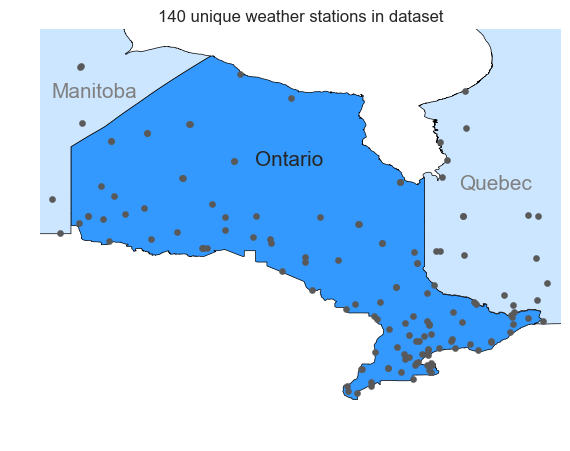

In [435]:
# take a look at where these stations are located
fig, ax = plt.subplots(figsize=(8,5),subplot_kw={'aspect':'equal', 'facecolor':'white'})
ontario.plot(legend=False, ax=ax, color=[0.2, 0.6, 1],edgecolor='black',linewidths=0.5);
manitoba.plot(legend=False, ax=ax, color=[0.8, 0.9, 1],edgecolor='black',linewidths=0.5);
quebec.plot(legend=False, ax=ax, color=[0.8, 0.9, 1],edgecolor='black',linewidths=0.5);
plt.scatter(wthr_stns_df.longitude, wthr_stns_df.latitude, facecolor=[0.35,0.35,0.35], s=20)
ax.set_xlim([-96.5, -73.5])
ax.set_ylim([41, 58])
plt.axis('off')
plt.text(-87,52,'Ontario', fontsize=15)
plt.text(-96,55,'Manitoba', fontsize=15, color = [0.5,0.5,0.5])
plt.text(-78,51,'Quebec', fontsize=15, color = [0.5,0.5,0.5])

plt.title(str(len(wthr_stns_df['station_id'].value_counts())) + ' unique weather stations in dataset')
plt.show();

In [401]:
# Determines naming scheme for each filename
def get_filenames(url, df):
    fndf = pd.read_fwf(url, names = ['a','b','c','d','e','f','g','h','filename'])
    split_fndf = fndf['filename'].str.split('-', expand=True)
    split_fndf.columns = ['a','b','c']
    subset = split_fndf[split_fndf['a'].isin(df['station_id'])]
    subset.loc[:,'filename'] = url + '/' + subset['a'] + '-' + subset['b'] + '-' + subset['c'] # reassemble filename
    subset = subset.drop(columns = ['a','b','c'])
    subset = subset.reset_index()
    return subset

In [402]:
# Converts units within each dataset
def convert_units(df):
    null_vals = [9999, 999, -0.9999, -9999]
    for val in null_vals:
        df.replace(val, np.nan, inplace=True)
    df.loc[:,'temp'] = df['temp'] * 0.1 * (9/5) + 32# in Farenheit
    df.loc[df['temp']>100, 'temp'] = 100
    df.loc[:,'dew_point'] = df['dew_point'] * 0.1 * (9/5) + 32 # in Farenheit
    df.loc[:,'pressure'] = df['pressure'] * 0.01 # in kPa
    df.loc[:,'pressure'] = df['pressure'].interpolate() # fill in some nan values present in the original data
    df.loc[:,'wind_speed'] = df['wind_speed'] * 0.2237 # in mph
    df.loc[:,'precip_1hr'] = df['precip_1hr'] * 0.003937007866 # in inches
    df.loc[:,'precip_6hr'] = df['precip_6hr'] * 0.003937007866 # in inches
    return df

In [403]:
# method to concatenate year, month, day, hour into datetime object
def concat_dt(df, year):
    # create datetime that we'll reference when we re-index the dataset
    df.loc[:,'datetime'] = df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + df['day'].astype('str') + '-' + df['hour'].astype('str')
    df.loc[:,'datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d-%H')
    df.loc[:,'datetime'] = df['datetime'].dt.strftime('%Y-%m-%d-%H')
    
    # Fill missing dates with nan then mean of the two data points on either side of it
    truedaterange = pd.date_range('01-01-'+str(year)+' 00:00:00', '12-31-'+str(year)+' 23:59:59', freq='H')
    df.index = pd.DatetimeIndex(df['datetime'])
    df = df.reindex(truedaterange, fill_value=np.nan)
    
    # Recover appropriate time parameters
    df.loc[:,'hour'] = df.index.hour
    df.loc[:,'day'] = df.index.day
    df.loc[:,'month'] = df.index.month
    df.loc[:,'year'] = df.index.year
    df.loc[:,'date'] = df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + df['day'].astype('str')
    df.loc[:,'date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.reset_index(inplace=True)
    df.drop(columns='datetime', inplace=True)
    df.rename(columns={'index':'datetime'}, inplace=True)
    
    # get rid of Feb 29th datas since they don't occur every year
    df = df.loc[df['date'] != dt.datetime(2016, 2, 29),:]
    return df

In [404]:
# Flags dataset for removal if it has a lot of missing data
def exclude_missing_data(df):
    flag_for_removal = False
    n_null_temp = sum(df['temp'].isna())
    n_null_wind_speed = sum(df['wind_speed'].isna())
    n_null_wind_dir = sum(df['wind_dir'].isna())
    n_null_pressure = sum(df['pressure'].isna())
    n_null_list = [n_null_temp, n_null_wind_speed, n_null_wind_dir, n_null_pressure]
    if any([x>876 for x in n_null_list]):
        flag_for_removal = True
    df = df.interpolate().ffill().bfill() # interpolate a few missing values
    return df, n_null_list, flag_for_removal

In [405]:
def load_weather_data(filenames, column_names, year, bad_stations):
    result = pd.DataFrame(data = [], columns = column_names + ['date','station_id','datetime'])
    n_stations_processed = 0
    n_stations_total = 0
    for file in filenames['filename']:
        while True:
            try:
                tmp = pd.read_fwf(file, names = column_names)
            except:
                continue
            break
        tmp = pd.read_fwf(file, names = column_names)
        tmp = convert_units(tmp)
        tmp = concat_dt(tmp, year)
        tmp, nl, ffr = exclude_missing_data(tmp)
        tmp.loc[:,'station_id'] = file[-20:-14]
        
        # only append if there is pressure and wind direction data available for the vast majority of the dataset
        if tmp.loc[:,'station_id'].values[0] in bad_stations:
            print('skipped station ' + str(file[-20:-14]) + ' - previously identified...' + str(n_stations_processed) + ' stations processed so far')
        elif ffr==True: # previously flagged for removal in `exclude_missing_data` function
            print('skipped station ' + str(file[-20:-14]) + ' - flagged for removal...' + str(n_stations_processed) + ' stations processed so far')
        elif tmp['pressure'].isnull().values[0] == True:
            print('skipped station ' + str(file[-20:-14]) + ' - no pressure data...' + str(n_stations_processed) + ' stations processed so far')
        elif tmp['wind_dir'].mean() < 20:
            print('skipped station ' + str(file[-20:-14]) + ' - no wind direction data...' + str(n_stations_processed) + ' stations processed so far')
        else:
            result = pd.concat([result,tmp], sort=False, axis=0)
            n_stations_processed+=1
        n_stations_total+=1
    print(str(n_stations_processed) + ' out of ' + str(n_stations_total) + ' stations passed data quality checkpoints')
    return result

In [406]:
# Pipeline of weather data injestion
try:
    # attempt to reload the previously saved unfiltered weather data
    weather_df = pd.read_csv('unfiltered_weather_df.csv')
    print('Yay! You\'ve already done the hard work of loading and cleaning data from the FTP servier. Off to the races!')
    print("")
    # Just need to fix date and datetime columns and remove the index (which was saved as a column named "Unnamed: 0"
    weather_df.drop(columns='Unnamed: 0', inplace=True)
    weather_df.loc[:,'station_id'] = weather_df['station_id'].astype('int')
    weather_df.loc[:,'date'] = pd.to_datetime(weather_df['date'], format='%Y-%m-%d')
    weather_df.loc[:,'datetime'] = pd.to_datetime(weather_df['datetime'], format='%Y-%m-%d %H')
except:
    print('We\'re in for the long haul...data needs to be loaded from the FTP server')
    print("")
    url = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/'
    column_names = ['year','month','day','hour','temp','dew_point','pressure','wind_dir','wind_speed','sky_conditions','precip_1hr','precip_6hr']
    bad_stations = ['710514','710720','710980','711450','711720','711830','711960','712080','712625',\
                    '712980','712990','713010','713030','713041','713720','713910','713980','714300',\
                    '714310','714340','714360','714390','714620','714630','714640','714650','715080',\
                    '715230','715320','715700','715870','716200','716220','716279','716300','716390',\
                    '716400','716420','716720','716780','716971','717320','717370','717380','717490',\
                    '717510','717550','718210','718220','718230','718240','718320','718330','718350',\
                    '718420','718436','718443','718450','718540','718964','719050','719053','719104',\
                    '719120','719470','719560','712970','714370','715240','717365','717366','718460',\
                    '710990','711930','712130','712950','713760','714330','715730','717493']
    weather_df = pd.DataFrame(columns = column_names + ['date','station_id','datetime'])
    for year in years:
        ftp_url = url + str(year) + '/'
        filenames = get_filenames(ftp_url, wthr_stns_df)
        station_weather_df = load_weather_data(filenames, column_names, year, bad_stations)
        print(station_weather_df.shape)

        # combine with previous years
        weather_df = pd.concat((weather_df, station_weather_df), sort=False, axis=0)
    weather_df.drop(columns=['sky_conditions', 'precip_1hr', 'precip_6hr'], inplace=True) # not going to be used in this analysis
    weather_df.loc[:,'wind_dir'] = weather_df['wind_dir'].astype('int') # these values are always in steps of 10 degrees
    weather_df.to_csv('unfiltered_weather_df.csv')

# Apply list of unique weather stations that passed QC to weather station metadata (wthr_stns_df)
good_weather_stations = np.unique(weather_df['station_id'].values)
wthr_stns_df.loc[:,'station_id'] = wthr_stns_df['station_id'].astype('int')
print('We began with ' + str(len(wthr_stns_df)) + ' weather stations')
print("")
good_wthr_stns_df = wthr_stns_df.loc[wthr_stns_df['station_id'].isin(good_weather_stations), :]
print('Now, only ' + str(len(good_wthr_stns_df)) + ' passed QC')

# join weather data with weather station metadata for full weather dataset
weather_df.set_index('station_id', inplace=True)
good_wthr_stns_df.set_index('station_id', inplace=True)

weather_df = weather_df.join(good_wthr_stns_df.loc[:,['latitude','longitude']])

weather_df.reset_index(inplace=True)
good_wthr_stns_df.reset_index(inplace=True)
display(weather_df.head(5))


Yay! You've already done the hard work of loading and cleaning data from the FTP servier. Off to the races!
We began with 140 weather stations
Now, only 68 passed QC


,year,month,day,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,station_id,datetime
0,2015,1,1,0,0.68,-3.64,99.85,330,25.2781,2015-01-01,710377,2015-01-01 00:00:00
1,2015,1,1,1,-6.88,-13.36,100.02,330,23.0411,2015-01-01,710377,2015-01-01 01:00:00
2,2015,1,1,2,-8.50,-15.88,100.11,330,20.8041,2015-01-01,710377,2015-01-01 02:00:00
3,2015,1,1,3,-8.14,-14.26,100.14,320,17.2249,2015-01-01,710377,2015-01-01 03:00:00
4,2015,1,1,4,-9.04,-13.90,100.22,320,19.4619,2015-01-01,710377,2015-01-01 04:00:00


In [17]:
ProfileReport(weather_df)

Number of variables,14
Number of observations,2557920
Total Missing (%),0.0%
Total size in memory,273.2 MiB
Average record size in memory,112.0 B
Numeric,11
Categorical,0
Boolean,0
Date,2
Text (Unique),0
Rejected,1


In [440]:
# plot some energy vs time
# visualize hourly wind power generation at station n
def plot_weather_data(df, station_id, column='wind_speed', year=2015, month=1, start_day=1, end_day=15):
    
    # convert dates to datetime format
    start_date = dt.datetime(year, month, start_day)
    end_date = dt.datetime(year, month, end_day)
    
    # data from single station
    tmpdf = df.loc[
        (df['datetime']>start_date) & 
        (df['datetime']<end_date) & 
        (df['station_id']==station_id)]
    
    # Construct plot
    f,ax = plt.subplots(figsize=(12,4))
    sns.lineplot(x='datetime', y=column, data=tmpdf, color="#95a5a6")
    ax.set_xlim([start_date, end_date])
    plt.xticks(rotation=90)
    ax.set_ylabel(column + ' at weather station #' + str(station_id))
    ax.set_xlabel('Date')
    plt.show();

In [441]:
interact(plot_weather_data,\
         df = fixed(weather_df),\
         station_id = good_weather_stations,\
         column = weather_df.columns[5:10],\
         year = years,\
         month = (1,12,1),\
         start_day = (1,31,1),\
         end_day = (1,31,1));

interactive(children=(Dropdown(description='station_id', options=(710377, 710630, 711510, 711610, 711710, 7126…

#### Combine weather + power data
 - Goal is to pair up weather stations and wind farms that are in close geographical proximity, effectively aligning these two distinct datasets in both space and time
 - Use wind farm and weather station metadata to determine which pairs of facilities are closest
 - Calculations follow the logic in [this post](https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates) and are just based on `latitude` and `longitude`, assuming (in this limited region) that the landscape can be approximated as a flat plane (I get to be a flat-earther for a bit!)

In [ ]:
from scipy import spatial

In [409]:
# calculate nearest neighbors and separation distance for weather station : wind farm combos
A = wind_farms_df.loc[:,['latitude','longitude']].values
B = good_wthr_stns_df.loc[:,['latitude','longitude']].values
inds = [spatial.KDTree(B).query(A[pt])[1] for pt in range(len(A))]
dists = [spatial.KDTree(B).query(A[pt])[0] for pt in range(len(A))]
miledists = [d*69 for d in dists] # convert to miles

In [410]:
# create dict of key:value pairs for wind farm : [weather_station, distance-to-weather-station] pairings
def pair_up(df1, df2, distances):
    pairs = {}
    for f, farm in enumerate(df1.loc[:,'station_name']):
        pairs[farm] = [df2.loc[inds[f],'station_id'], distances[f]]

    # make pairs into a data frame for joining
    tmp0 = pd.DataFrame(pd.DataFrame(pairs).iloc[0,:].astype(int))
    tmp1 = pd.DataFrame(pd.DataFrame(pairs).iloc[1,:])
    pairs = pd.concat((tmp0,tmp1),axis=1)
    pairs.columns=['station_id','distance']

    # make sure indices of `pairs` and `weather_df` match up
    pairs.reset_index(inplace=True)
    pairs.rename(columns={'index':'station_name'}, inplace=True)
    return pairs

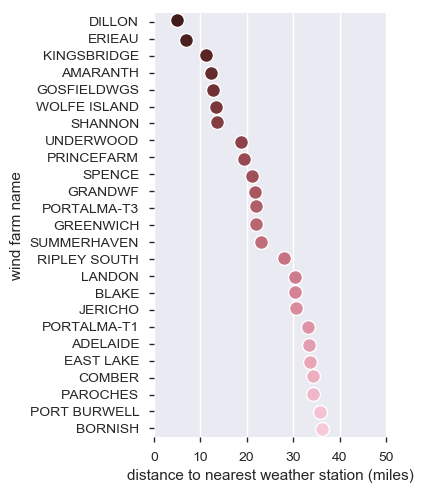

In [443]:
# Visualize distances between pairs of weather stations and wind farms
pairs = pair_up(wind_farms_df, good_wthr_stns_df, miledists)
f, ax = plt.subplots(figsize=(3,5.5))
sns.stripplot(x="distance", y="station_name", data=pairs.sort_values("distance", ascending=True),\
        size=10, orient="h", palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")
ax.set_xlabel('distance to nearest weather station (miles)')
ax.set_ylabel('wind farm name')
ax.set_xlim([0,50])
plt.show();

All weather stations are within 40 miles of their respective wind farms - GOOD!

Expect wind farms with smaller distances to the nearest weather station to provide more reliable data to analyze.

As a representative case we'll examine KINGSBRIDGE wind farm, which has a weather station ~10miles away.<br><br><br>

In [23]:
### JOIN pairs with weather_df ###
# make pairs df with station_id index
pairs1 = pair_up(wind_farms_df, good_wthr_stns_df, miledists)

pairs1.set_index('station_id', inplace=True)
# display(pairs1.head(2))

joinable_weather_df = weather_df.set_index('station_id')
joinable_weather_df = joinable_weather_df.sort_values(['station_id', 'datetime'])
# display(joinable_weather_df.head(2))

# Join and do some final cleaning up of column names
final_weather_df = joinable_weather_df.join(pairs1).reset_index()
final_weather_df.dropna(inplace=True) # remove those that didn't match up
final_weather_df.reset_index(inplace=True) # recover station_id column
final_weather_df.drop(columns='index', inplace=True)
final_weather_df = final_weather_df.loc[final_weather_df['distance']<=50, :]
final_weather_df = final_weather_df.sort_values(['station_name', 'datetime']).reset_index()
final_weather_df = final_weather_df.drop(columns = 'index')
# display(final_weather_df.head(2))

In [24]:
### JOIN pairs with output_df ###
# make pairs df with station_name index
pairs2 = pair_up(wind_farms_df, good_wthr_stns_df, miledists)
pairs2.set_index('station_name', inplace=True)
# display(pairs2.head(2))

joinable_output_df = output_df.set_index('station_name')
joinable_output_df = joinable_output_df.sort_values(['station_name', 'datetime'])
# display(joinable_output_df.head(2))

# Join and do some final cleaning up of column names and data to exclude
final_output_df = joinable_output_df.join(pairs2).reset_index()
final_output_df = final_output_df.loc[final_output_df['distance']<=50,:]
final_output_df = final_output_df.sort_values(['station_name', 'datetime']).reset_index()
final_output_df = final_output_df.drop(columns = 'index')
# display(final_output_df.head(2))

In [25]:
# Triple check that we have indexed everything correctly
print(len(final_output_df))
print(len(final_weather_df))
print(sum(final_output_df.datetime==final_weather_df.datetime))

876000
876000
876000


In [27]:
def shift_datetime(df, stations, shift_cols, noshift_cols, shift=-5):
    result = pd.DataFrame(columns = noshift_cols + shift_cols)
    for station in stations:
        # shift columns corresponding to weather data backwards in time (from UTC to EST)
        shiftdf = df.loc[df['station_name']==station, shift_cols]
        shiftdf = shiftdf.shift(periods=shift)
        shiftdf = shiftdf.dropna()
        shiftdf = shiftdf.reset_index()
        shiftdf = shiftdf.drop(columns='index')
        
        # don't shift, but truncate the other columns of the dataframe (keeping datetime)
        noshiftdf = df.loc[df['station_name']==station, noshift_cols]
        noshiftdf = noshiftdf.iloc[:shift]
        noshiftdf = noshiftdf.reset_index()
        noshiftdf = noshiftdf.drop(columns='index')
                
        # combine shift + noshift
        shifted_df = pd.concat((noshiftdf, shiftdf), sort=False, axis=1)
        
        # append to end of growing result
        result = pd.concat((result, shifted_df), sort=False, axis=0)
    return result

In [28]:
# join power and weather together into one final dataset for analysis and time-series modeling
wthrfeats = ['station_name', 'datetime', 'hour', 'day', 'month', 'year', 'wind_speed', 'wind_dir', 'temp', 'dew_point', 'pressure', 'latitude', 'longitude']
pwrfeats = ['station_name', 'datetime', 'power_output', 'pred_power_output', 'pmax_power_output', 'pred_pmax_power_output']
df1 = final_output_df.loc[:, pwrfeats].rename(columns={'datetime':'datetime_pwr', 'station_name':'station_name_pwr'})
df2 = final_weather_df.loc[:, wthrfeats].rename(columns={'datetime':'datetime_wthr', 'station_name':'station_name_wthr'})
stations = list(final_output_df.groupby('station_name').count().index)
df = df1.join(df2)
df = df.drop(columns=['datetime_wthr','station_name_wthr']).rename(columns={'datetime_pwr':'datetime', 'station_name_pwr':'station_name'})

# realized that we have EST for power data, but UTC for weather data
# As a result, we need to shift the data around to make them align in time
noshift_cols = ['station_name','datetime','power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','hour','day','month','year']
shift_cols = ['wind_speed','wind_dir','temp','dew_point','pressure','latitude','longitude']
df = shift_datetime(df, stations, shift_cols, noshift_cols, shift=-5)

#recover datetime index
df.set_index('datetime', inplace=True)

station_name                      object
datetime                  datetime64[ns]
power_output                     float64
pred_power_output                float64
pmax_power_output                float64
pred_pmax_power_output           float64
hour                               int64
day                                int64
month                              int64
year                               int64
wind_speed                       float64
wind_dir                           int64
temp                             float64
dew_point                        float64
pressure                         float64
latitude                         float64
longitude                        float64
dtype: object

876000


,station_name,power_output,pred_power_output,pmax_power_output,pred_pmax_power_output,hour,day,month,year,wind_speed,wind_dir,temp,dew_point,pressure,latitude,longitude
datetime,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,ADELAIDE,58.0,57.0,0.983051,0.966102,0,1,1,2015,19.6856,240.0,17.60,3.20,101.78,43.036,-81.154
2015-01-01 01:00:00,ADELAIDE,57.0,57.0,0.966102,0.966102,1,1,1,2015,21.9226,240.0,16.88,4.82,101.71,43.036,-81.154
2015-01-01 02:00:00,ADELAIDE,56.0,55.0,0.949153,0.932203,2,1,1,2015,18.3434,240.0,17.60,6.80,101.69,43.036,-81.154
2015-01-01 03:00:00,ADELAIDE,58.0,57.0,0.983051,0.966102,3,1,1,2015,16.1064,230.0,17.60,8.60,101.68,43.036,-81.154
2015-01-01 04:00:00,ADELAIDE,58.0,58.0,0.983051,0.983051,4,1,1,2015,18.3434,210.0,17.60,8.60,101.62,43.036,-81.154
2015-01-01 05:00:00,ADELAIDE,57.0,57.0,0.966102,0.966102,5,1,1,2015,17.2249,230.0,17.60,8.60,101.57,43.036,-81.154
2015-01-01 06:00:00,ADELAIDE,57.0,57.0,0.966102,0.966102,6,1,1,2015,18.3434,230.0,17.60,8.60,101.56,43.036,-81.154


station_name               object
power_output              float64
pred_power_output         float64
pmax_power_output         float64
pred_pmax_power_output    float64
hour                       object
day                        object
month                      object
year                       object
wind_speed                float64
wind_dir                  float64
temp                      float64
dew_point                 float64
pressure                  float64
latitude                  float64
longitude                 float64
dtype: object

875875


### Part 2: Exploratory Data Analysis

We'll perform a search for seasonality in energy generation and weather data using two different techniques/visualizations:

__First, look at simple moving averages in weather and power output at different time-scales__
 - yearly (with temperature changes)
 - daily (with sun rise and set)

In [436]:
# yearly average and moving average
def yearly_avg(df, yvar='power_output', station='KINGSBRIDGE'):
    df = df.loc[df['station_name']==station]
    
    # visualize yearly average (day-by-day)
    avg_df = pd.DataFrame(df[yvar].groupby([(df.index.month),(df.index.day)]).mean())
    newindex = pd.DataFrame(avg_df.index.values)
    newindex['datetime'] = ['2019-' + '%02d' % x + '-' + '%02d' % y for x, y in newindex.loc[:,0]]
    avg_df.set_index(newindex['datetime'], inplace=True)
    avg_df.reset_index(inplace=True)

    # calculate moving average as well (average over 14 days)
    mvavg_df = pd.DataFrame(avg_df[yvar].rolling(14).mean())
    mvavg_df.set_index(newindex['datetime'], inplace=True)
    mvavg_df.reset_index(inplace=True)

    # clean up stupid leap year days and datetime columns
    avg_df = avg_df.loc[avg_df['datetime']!='2019-02-29',:]
    avg_df['datetime'] = pd.to_datetime(avg_df['datetime'], format = '%Y-%m-%d')
    mvavg_df = mvavg_df.loc[mvavg_df['datetime']!='2019-02-29',:]
    mvavg_df['datetime'] = pd.to_datetime(mvavg_df['datetime'], format = '%Y-%m-%d')

    # plot avg and moving average of the average
    fig,ax = plt.subplots(figsize=(8,4))
    sns.lineplot(x="datetime", y=yvar, data=avg_df, label='4-year avg', color='#3498db');
    sns.lineplot(x="datetime", y=yvar, data=mvavg_df, label= '2-week moving avg', color='#e74c3c', ax=ax);
    ax.set_title('Data for wind farm: ' + station)
    ax.set_xlabel('Date')
    
    # Clean up axes
    xmin = 737060
    xmax = 737425
    ax.set_xticks(np.linspace(xmin, xmax, 13))
    ax.set_xticklabels(['Jan 1st','Feb 1st','Mar 1st','Apr 1st','May 1st','Jun 1st','Jul 1st','Aug 1st','Sep 1st','Oct 1st','Nov 1st','Dec 1st','Dec31st'])
    plt.xticks(rotation=45)
    ax.set_xlim([xmin,xmax])
    ax.legend(loc = 'upper center', ncol = 2);

In [437]:
yvars = ['power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','wind_speed','wind_dir','temp','dew_point','pressure']
interact(yearly_avg, df = fixed(df), yvar = yvars, station = stations);

interactive(children=(Dropdown(description='yvar', options=('power_output', 'pred_power_output', 'pmax_power_o…

Yearly seasonality is farily strong and repeatable station-to-station. During the summer months, power output appears to decrease to ~30% of the average output that occurs in December/January.

This indicates that we should incorporate `month` as a predictor in time-series modeling.
<br><br><br>

In [438]:
def daily_avg(df, yvar='power_output', station='KINGSBRIDGE'):
    months = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    month_names = list(months.keys())
    clrs = sns.color_palette("hls", 12)
    clrs = clrs[-6:] + clrs[:6]
    fig,ax = plt.subplots(figsize=(6,4))
    
    df = df.loc[df['station_name']==station,:]

    # visualize daily average (hour-by-hour)
    avg_df = pd.DataFrame(df[yvar].groupby([(df.index.month), (df.index.hour)]).mean())
    avg_df.reset_index(level = 0, inplace=True)
    avg_df.columns = ['month', yvar]
    avg_df.reset_index(level=0, inplace=True)
    avg_df.columns = ['hour','month', yvar]

    # clean up datetime columns
    avg_df['datetime'] = ['2019-01-01 ' + '%02d' % x + ':00:00' for x in avg_df['hour'].values]
    avg_df['datetime'] = pd.to_datetime(avg_df['datetime'], format = '%Y-%m-%d %H')

    # plot avg metrics
    xmin = 737060
    xmax = 737060.95
    sns.lineplot(x="datetime", y=yvar, hue='month', data=avg_df, palette=clrs, ax=ax);
    ax.set_title('Data for wind farm: ' + station)
    ax.set_xlabel('Hour of the day')
    plt.xticks(rotation=45)
    ax.set_xlim([xmin, xmax])
    ax.set_xticks(np.linspace(xmin, xmax, 7))
    ax.set_xticklabels(['12:00 AM','4:00 AM','8:00 AM','12:00 PM','4:00 PM','8:00 PM','11:59 PM'])
    ax.legend(labels = month_names, bbox_to_anchor=(1.02, 0.9), title='Month');

In [439]:
yvars = ['power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','wind_speed','wind_dir','temp','dew_point','pressure']
interact(daily_avg, df = fixed(df), yvar = yvars, station = stations);

interactive(children=(Dropdown(description='yvar', options=('power_output', 'pred_power_output', 'pmax_power_o…

Hourly changes in power output seem to be season-dependent. However, there are still patterns if you look at individual months/seasons.

Incorporating `hour` of the day should still add some predictive power to the model.<br><br><br>

__Next, we'll examine auto-correlation plots__
 - To what extent can present values for power output be used to predict future values?
 - Are there any autocorrelation patterns that repeat for multiple metrics?

In [34]:
from pandas.plotting import autocorrelation_plot

In [35]:
# Autocorrelation plot
def autoplot_alias(df, station='KINGSBRIDGE', yvar='power_output', tspan='day', t=2):
    f, ax = plt.subplots(figsize=(4,3))
    df = df.loc[df['station_name']==station, yvar]
    if tspan=='day':
        tsp = 1 * 24
        yrange = (-1,1)
    elif tspan=='week':
        tsp = 7 * 24
        yrange = (-1,1)
    elif tspan=='month':
        tsp = 30 * 24
        yrange = (-0.5,0.5)
    elif tspan=='year':
        tsp = 365*24
        yrange = (-.2,.2)
    else:
        return 'error'
    xrange = (0, tsp-1)
    autocorrelation_plot(df[tsp*t:tsp*(t+1)], ax=ax) # 1 week worth of data, we'll be able to scroll through weeks
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.set_xlabel('Lag (hours)')

In [36]:
# hourly analysis
yvars = ['power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','wind_speed','wind_dir','temp','dew_point','pressure']
interact(autoplot_alias, df=fixed(df), station=stations, yvar=yvars,\
         tspan=fixed('day'), t = (0,20,1));

interactive(children=(Dropdown(description='station', index=12, options=('ADELAIDE', 'AMARANTH', 'BLAKE', 'BOR…

Autocorrelations quickly drop to zero off after ~5hrs, indicating that naive wind energy forecasts (future energy output = current energy output) would only be reliable up to ~2.5hrs in the future.

Autocorrelation plots for both `power output` and `wind speed` look very similar --> supports using `wind speed` as a predictor in time-series modeling. `temperature` also follows a similar, even stronger pattern.<br><br><br>

In [37]:
# yearly analysis
interact(autoplot_alias, df=fixed(df), station=stations, yvar=yvars,\
         tspan=fixed('year'), t = (0,3,1));

interactive(children=(Dropdown(description='station', index=12, options=('ADELAIDE', 'AMARANTH', 'BLAKE', 'BOR…

Autocorrelations in power output at longer yearly time-scale is stronger, but still relatively small in magnitude.

Again, plots for both `power output` and `wind speed` look very similar.

##### Take-homes from exploratory analysis:
 - Variability in both weather and power data far outweigh seasonal trends at the daily and yearly time-scale
 - Observe repeatable patterns in autocorrelation plots, indicating links between `wind speed`, `power output`, and possibly `temperature` --> necessitates using a time-series forecasting model that supports __multivariate predictors__.
 - These findings motivate the use of more __advanced modeling technique (LSTM)__ as opposed to more classic techniques that require strong/repeatable auto-correlations in data for accurate modeling.<br><br><br>

### Part 3: Time-series modeling

#### Diagram of time-series analysis predictions:

In [38]:
# classes and methods for pipeline assembly
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

#### 1) Create several custom transformers
 - `FeatureSelector`: feed specific features (columns) of data into pipelines (join them with `FeatureUnion` later)
 - `QuickReshape`: re-orders columns output from `OneHotEncoder` to be utilized in LSTM structure
    - e.g. `[A1, B1, A2, B2, A3, B3]` --> `[A1, A2, A3, B1, B2, B3]` where `A` and `B` are predictors and `1`, `2`, `3` refer to timepoints
 - `TimeTransform`: time-adjust predictors for LSTM (see above for illustrative diagram of how weather and power variables are combined for predictions

In [39]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names):
        self._feature_names = feature_names
    
    def fit(self, X, y=None):
        return self # nothing else to do here

    def transform(self, X, y=None):
        X = X.loc[:, self._feature_names]
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)
        return X # return the features of interest, still in a df, even if a single column

In [40]:
#Custom Transformer that just reshapes the ouptut of a previous transformer
class QuickReshape(BaseEstimator, TransformerMixin):

    def __init__( self, h_past, h_fut, style, order, shifted = False ):
        self.h_past = h_past
        self.h_fut = h_fut
        self.style = style
        self.order = order
        if shifted:
            self.shift = h_fut
        else:
            self.shift = 0
    
    def fit(self, X, y=None):
        return self # nothing else to do here

    def transform(self, X, y=None):
        # figure out which way to transform the data
        if self.style == 'lag':
            off = self.h_past-self.shift
        elif self.style == 'fut':
            off = self.h_fut
                        
        n_features = X.shape[1]//off
        
        return X.reshape((X.shape[0], off, n_features), order = self.order)

In [41]:
#### Custom Transformer ####
# Creates a numpy.array with lag predictors from any dataset
#   - starting h_past hours ago
class TimeTransform(BaseEstimator, TransformerMixin):

    def __init__( self, h_past, h_fut, style, shifted = False ):
        self.h_past = h_past
        self.h_fut = h_fut
        self.style = style
        if shifted:
            self.shift = h_fut
        else:
            self.shift = 0
    
    def fit( self, X, y = None ):
        return self
    
    def transform( self, X, y = None ):
        # figure out which way to transform the data
        if self.style == 'lag':
            off = self.h_past - self.shift
            correction = self.h_fut + self.shift
            fut_offset = self.shift
        elif self.style == 'fut':
            off = self.h_fut
            correction = self.h_past
            fut_offset = self.h_past
                
        # initialize empty matrix to which offset variables will be concatenated
        n_features = np.shape(X)[1]
        offset_vars = np.empty((len(X) - off - correction + 1, 0))
        if isinstance(X,pd.DataFrame):
            X = X.values
        for col in range(n_features):
            nooff = X[:, col]
            nrows = len(nooff) - off - correction + 1
            offset = np.empty((0, ))
            for n in range(off):
                start = n + fut_offset
                end = nrows + n + fut_offset
                offset = np.concatenate((offset, nooff[start:end]), axis=0)
            offset = np.reshape(offset, (nrows, off), order='F')
            offset_vars = np.concatenate((offset_vars, offset), axis=1)
        return offset_vars

#### 2) Parameters and model structure

In [197]:
# define parameters dictating model structure
station = 'KINGSBRIDGE'
yvar = 'pmax_power_output'
nfuts = 168 # for just wthr for which we have forecasts n futs hours in advance
nlags = nfuts+24 # for both wthr and pwr datasets we have data for the past 24 hours

# features to use in prediction
power_features = ['pmax_power_output']
weather_features = ['wind_speed', 'temp', 'pressure'] # left out: 'dew_point' (highly correlated with temp)
categorical_features = ['hour', 'month'] # left out: 'wind_dir' (tricky for one-hot-encoding)

# pre-define training and testing dfs for future use in pipelines:
training_df = df.loc[(df['year'] == 2017) & (df['station_name'] == station), :]
tmp_testing_df = df.loc[(df['year'] == 2018) & (df['station_name'] == station), :]
# add nlags from training dataset onto testing dataset in order to make predictions of the first point in the test dataset
testing_df = pd.concat((training_df[-(nlags+nfuts):], tmp_testing_df), axis = 0)

array([[ 1.57921965,  0.95361419, -1.01020201],
       [ 1.50212788,  1.14270173, -0.98853737],
       [ 1.7334032 ,  1.14270173, -0.97770504],
       [ 1.65631142,  1.14270173, -0.96687272],
       [ 1.27085257,  0.95361419, -0.98853737],
       [ 0.88539371,  0.57543913, -1.01020201],
       [ 0.19156777,  0.38635159, -1.05353131],
       [-0.27098286,  0.15944655, -1.07519596]])

8760


In [198]:
######## PAST POWER FEATURES ########
# Define features and steps in power_pipeline
power_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( power_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag' ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'F' ) ) ] )



######## PAST AND FUTURE WEATHER FEATURES ########
# Define features and steps in the past_weather_pipeline
past_weather_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( weather_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag', shifted = True ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'F', shifted = True ) ) ] )

# Define features and steps in the future_weather_pipeline
future_weather_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( weather_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'fut' ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'fut', order = 'F' ) ) ] )

# FeatureUnion past and future weather
weather_union = FeatureUnion( transformer_list = [
    ( 'past_weather_pipeline', past_weather_pipeline ),
    ( 'future_weather_pipeline', future_weather_pipeline ) ] )



######## PAST AND FUTURE CATEGORICAL FEATURES ########
# Define features and steps in the past_categorical_pipeline 
past_categorical_pipeline = Pipeline( steps = [
    ( 'cat_selector', FeatureSelector( categorical_features ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag', shifted = True ) ),
    ( 'one_hot_encoder', OneHotEncoder( categories = 'auto', sparse = False) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'C', shifted = True ) ) ] )

# Define features and steps in the future_categorical_pipeline 
future_categorical_pipeline = Pipeline( steps = [
    ( 'cat_selector', FeatureSelector( categorical_features ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'fut' ) ),
    ( 'one_hot_encoder', OneHotEncoder( categories = 'auto', sparse = False) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'fut', order = 'C' ) ) ] )

# FeatureUnion past and future categorical features
categorical_union = FeatureUnion( transformer_list = [
    ( 'past_categorical_pipeline', past_categorical_pipeline ),
    ( 'future_categorical_pipeline', future_categorical_pipeline ) ] )

#### 3) Create training and testing datasets

In [199]:
# functions to split data into training and testing
def train_test(df, nlags, nfuts, yvar):
    # X (features)
    d1 = power_pipeline.fit_transform(df)
    d2 = weather_union.fit_transform(df)
    d3 = categorical_union.fit_transform(df)
    X = np.concatenate((d1, d2, d3), axis=2)
    
    # y (predicted)
    SS = StandardScaler()
    y = df.loc[:, yvar].values
    y = SS.fit_transform(y.reshape(-1, 1))
    y = y[nlags + nfuts - 1:]
    return X, y, SS

In [200]:
# split data into training and testing subsets
X_train, y_train, SS_train = train_test(training_df, nlags, nfuts, yvar)
X_test, y_test, SS_test = train_test(testing_df, nlags, nfuts, yvar)

# triple check X and y are the same shape and appropriately aligned
n_features = np.shape(X_train)[2]
print('dimension\ttrain\ttest\texpected')
print(' nlags  \t ' + str(np.shape(X_train)[1]) + '\t ' + str(np.shape(X_test)[1]) + '\t   ' + str(nlags))
print(' n_feats\t ' + str(np.shape(X_train)[2]) + '\t ' + str(np.shape(X_test)[2]) + '\t   ' + str(n_features))
print(' X_rows \t' + str(np.shape(X_train)[0]) + '\t' + str(np.shape(X_test)[0]))
print(' y_rows \t' + str(np.shape(y_train)[0]) + '\t' + str(np.shape(y_test)[0]))

dimension	train	test	expected
 nlags  	 192	 192	   192
 n_feats	 40	 40	   40
 X_rows 	8401	8756
 y_rows 	8401	8756


#### 4) Construct LSTM model
A LOT of optimization can be done here. In order to efficiently and systematically explore the various model architectures and hyperparameters, I created a function `train_LSTM_model` that
 1) takes all these variables as inputs (hyperparameters, how many layers, what types of hidden layers etc.)
 2) fits a model until the validation loss no longer improves (using various checkpoint and early stopping tools)
 3) saves the parameters of that model in the filename of both
    - model .hdf5 file
    - model loss-vs-epochs plot .png fileNotes on compile (precompute step)
    
Following these two resources ([link1](https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/), [link2](https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/)), the hyperparameters and model architectural elements I examined are:

 1) `layers`: Number of hidden layers (up to 3)
 
 2) `dropout_rate`: the rate at which nodes are left out of training in the dropout layer
 
 3) `kernel_reg_alpha`: regularization alpha parameter that penalizes large weights during training
 
 4) `learning_rate`: learning rate for the `adam` optimizer
 
 
__Note:__ I have not examined the relative accuracy of various optimization algorithms yet. I chose to use the ADAM `adam` algorithm due to its prevalence in the literature. It also requires fewer hyperparameter optimizations (e.g. stochastic gradient descent `sgd` requires tuning of both the learning rate AND `momentum` parameters).

In [79]:
# Import modeling packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

# operating system library for saving files
import os

In [201]:
# function to allow flexible and fast training of multiple LSTM models with various hyperparameters and structures
def train_LSTM_model(epochs, layers, LSTM_units, dropout_rate, kernel_reg_alpha, optimizer_name, learn_rate, save_folder):
    # see if certain parameters were supplied:
    # dropout layer
    dropout = False
    if dropout_rate is not None:
        dropout = True
    # kernel regularization
    kernel_reg = False
    if kernel_reg_alpha is not None:
        kernel_reg = True
        
    # Figure out what kind of optimizer we supplied
    if optimizer_name == 'Adam':
        optimizer = Adam(lr = learn_rate)
        # other adam specific params
    elif optimizer_name == 'SGD':
        optimizer = SGD(lr = learn_rate)
        # other stochastic gradient descent specific params
        
        
    # all optimizers are going to have a learning rate
    learn_rate_str = '{}'.format( str(learn_rate).replace('.','p') )
    
    # Keep track of parameters in filename
    model_name = '{}_{}hrs_{}_{}lr_{}epochs_{}lyrs_{}unts'.format(station[:5], nfuts, optimizer_name, learn_rate_str, epochs, layers, LSTM_units)
    if dropout:
        rate = dropout_rate
        model_name += '_{}drp'.format( str(rate).replace('.','p') )
    else:
        model_name += '_nodrop'
    if kernel_reg:
        alpha = kernel_reg_alpha
        model_name += '_{}kreg'.format( str(alpha).replace('.','p').replace('-','') )
    else:
        model_name += '_nokreg'

    seq_return = [True]*(layers-1) + [False]


    # Build Model
    model = Sequential()

    # Depending on model structure and parameters, add various layers
    for i in range(layers):

        # Do we need to feed sequences to next layer of the network?
        if i == 1:
            model.add(LSTM(LSTM_units, return_sequences = seq_return[i], input_shape=(nlags, n_features)))
        else:
            model.add(LSTM(LSTM_units, return_sequences = seq_return[i]))

        # Do we add a dropout layer?
        # - requires that important features are distributed amongst several nodes
        if dropout:
            model.add(Dropout(rate = rate))

        # Do we regularize?
        # - penalizes large weights and avoids overfitting
        if kernel_reg:
            model.add(Dense(1, kernel_regularizer=regularizers.l2(alpha)))
        else:
            model.add(Dense(1))

    # make some places to save models
    if not os.path.isdir("./models/" + save_folder):
        os.mkdir("./models/" + save_folder)
    if not os.path.isdir("./model_evaluation/" + save_folder):
        os.mkdir("./model_evaluation/" + save_folder)
    
    # use these tools to avoid overfitting
    checkpointer = ModelCheckpoint(filepath='./models/' + save_folder + '/' + model_name + '.hdf5',
                                   monitor='val_loss',
                                   verbose=0, save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', patience=5,
                                  verbose=0, min_delta=.001)        

    # compile and fit the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=168,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpointer, earlystopping],
                        verbose = 0)

    # Plot training & validation loss values
    f, ax = plt.subplots(figsize=(4,3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xlim([0, epochs])
    ax.set_ylim([0.05, 0.5])
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.gcf().subplots_adjust(bottom=0.1, left = 0.05)
    plt.savefig('./model_evaluation/' + save_folder + '\{}.png'.format(model_name))
    return np.array(history.history['val_loss'])

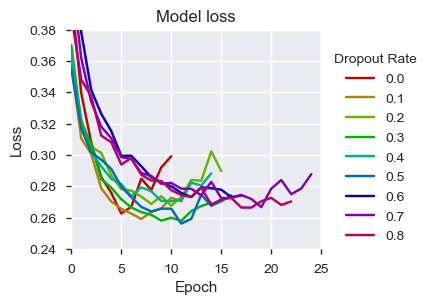

In [163]:
###### Examine dropout_rate hyperparameter ######
epochs = 40
layers = 1
LSTM_units = 50
dropout_rate = [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
kernel_reg_alpha = 5 * 10 ** -6 # default
optimizer_name = 'Adam'
learn_rate = 0.001 # default
save_folder = 'dropout_rates'
history = [[]]*len(dropout_rate)
for d, rate in enumerate(dropout_rate):
    history[d] = train_LSTM_model(epochs, layers, LSTM_units, rate, kernel_reg_alpha, optimizer_name, learn_rate, save_folder)

# Plot all loss-epochs curves together
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
clrs = sns.hls_palette(len(dropout_rates), l=.35, s=1)
f, ax = plt.subplots(figsize=(5,3))

for d, rate in enumerate(dropout_rates):
    plt.plot(history[d].history['val_loss'], color = clrs[d], label = dropout_rates[d])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim([0, 25])
ax.set_ylim([0.24, 0.38])
ax.legend(title='Dropout Rate', bbox_to_anchor=(1, 0.95))
plt.gcf().subplots_adjust(bottom=0.15, left = 0.2, right = 0.7)
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.png')
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.jpg')

`0.3` appears to be the optimal `dropout_rate`<br><br><br>

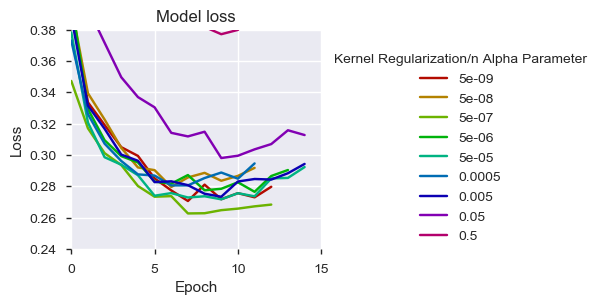

In [175]:
###### Examine kernel_reg_alpha hyperparameter ######
epochs = 40
layers = 1
LSTM_units = 50
dropout_rate = 0.3 # optimized
kernel_reg_alpha = [5*10**-9, 5*10**-8, 5*10**-7, 5*10**-6, 5*10**-5, 5*10**-4, 5*10**-3, 5*10**-2, 5*10**-1]
optimizer_name = 'Adam'
learn_rate = 0.001 # default
save_folder = 'kernel_reg_alpha'
history = [[]]*len(kernel_reg_alpha)
for a, alpha in enumerate(kernel_reg_alpha):
    history[a] = train_LSTM_model(epochs, layers, LSTM_units, dropout_rate, alpha, optimizer_name, learn_rate, save_folder)
    
# Plot all loss-epochs curves together
kernel_reg_alpha = [5*10**-9, 5*10**-8, 5*10**-7, 0.000005, 5*10**-5, 5*10**-4, 5*10**-3, 5*10**-2, 5*10**-1]
clrs = sns.hls_palette(len(kernel_reg_alpha), l=.35, s=1)
f, ax = plt.subplots(figsize=(5,3))

for a, alpha in enumerate(kernel_reg_alpha):
    plt.plot(history[a], color = clrs[a], label = kernel_reg_alpha[a])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim([0, 15])
ax.set_ylim([0.24, 0.38])
ax.legend(title='Kernel Regularization\n Alpha Parameter', bbox_to_anchor=(1, 0.95))
plt.gcf().subplots_adjust(bottom=0.15, left = 0.2, right = 0.7)
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.png')
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.jpg')

`5e-7` ends up being optimal `alpha` for regularization<br><br><br>

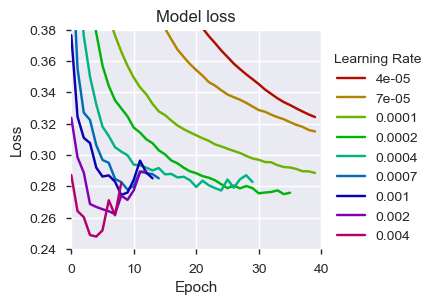

In [180]:
###### Examine learn_rate hyperparameter ######
epochs = 40
layers = 1
LSTM_units = 50
dropout_rate = 0.3 # optimized
kernel_reg_alpha = 5*10**-7 # optimized
optimizer_name = 'Adam'
learn_rates = [0.00004, 0.00007, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004]
save_folder = 'learning_rate'
history = [[]]*len(learn_rates)
for lr, learn_rate in enumerate(learn_rates):
    history[lr] = train_LSTM_model(epochs, layers, LSTM_units, dropout_rate, kernel_reg_alpha, optimizer_name, learn_rate, save_folder)
    
# Plot all loss-epochs curves together
learning_rates = [0.00004, 0.00007, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004]
clrs = sns.hls_palette(len(learning_rates), l=.35, s=1)
f, ax = plt.subplots(figsize=(5,3))

for lr, learn_rate in enumerate(learning_rates):
    plt.plot(history[lr], color = clrs[lr], label = learning_rates[lr])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim([0, 40])
ax.set_ylim([0.24, 0.38])
ax.legend(title='Learning Rate', bbox_to_anchor=(1, 0.95))
plt.gcf().subplots_adjust(bottom=0.15, left = 0.2, right = 0.7)
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.png')
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.jpg')

Somewhat non-intuitively, faster `learning_rate`s actuall ended up yielding higher-accuracy (lower loss) models.

Preliminarily, `0.004` appears to be the optimal `learning_rate`, but it was at the edge of our parameter space.

Lets examine even faster learning rates and see if we can make them even better.<br><br><br>

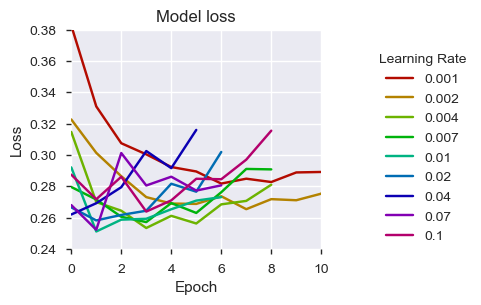

In [192]:
###### Examine learn_rate hyperparameter AGAIN ######
epochs = 40
layers = 1
LSTM_units = 50
dropout_rate = 0.3 # optimized
kernel_reg_alpha = 5*10**-7 # optimized
optimizer_name = 'Adam'
learn_rates = [0.001, 0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1]
save_folder = 'learning_rate_faster_ones'
history = [[]]*len(learn_rates)
for lr, learn_rate in enumerate(learn_rates):
    history[lr] = train_LSTM_model(epochs, layers, LSTM_units, dropout_rate, kernel_reg_alpha, optimizer_name, learn_rate, save_folder)
    
# Plot all loss-epochs curves together
learning_rates = [0.001, 0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1]
clrs = sns.hls_palette(len(learning_rates), l=.35, s=1)
f, ax = plt.subplots(figsize=(5,3))

for lr, learn_rate in enumerate(learning_rates):
    plt.plot(history[lr], color = clrs[lr], label = learning_rates[lr])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim([0, 10])
ax.set_ylim([0.24, 0.38])
ax.legend(title='Learning Rate', bbox_to_anchor=(1.18, 0.95))
plt.gcf().subplots_adjust(bottom=0.15, left = 0.2, right = 0.7)
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.png')
plt.savefig('model_evaluation/' + save_folder + '/all_models_compared.jpg')

`0.004` still appears to be the optimal `learning_rate`<br><br><br>

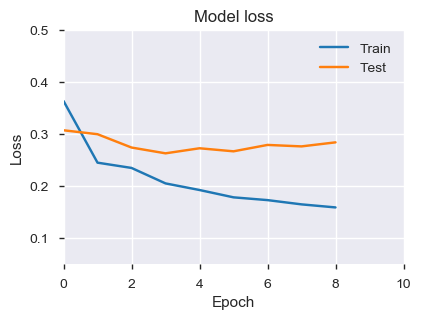

In [202]:
# ###### Train 168 hr (1 week) forecast model using optimal hyperparameters/structure ######
# epochs = 10
# layers = 1
# LSTM_units = 50
# dropout_rate = 0.3 # optimized
# kernel_reg_alpha = 5*10**-7 # optimized
# optimizer_name = 'Adam'
# learn_rate = 0.004
# save_folder = 'optimized_models'
# history = train_LSTM_model(epochs, layers, LSTM_units, dropout_rate, kernel_reg_alpha, optimizer_name, learn_rate, save_folder)
# display('Min Validation Error: ' + str(min(history.history['val_loss'])))

In [204]:
# Visualize 1 week ahead forecast
# 0) re-load optimal model
opt_model = load_model('models\optimized_models\KINGS_168hrs_Adam_0p004lr_10epochs_1lyrs_50unts_0p3drp_5e07kreg.hdf5')

# 1) Make predictions using optimal model
y_pred = opt_model.predict(X_test)
y_pred = np.reshape(y_pred,(len(y_pred), ))
y_pred = SS_test.inverse_transform(y_pred) # recover initial values
y_pred = y_pred[1:]

# 2) Make naiive predictions where next week = previous week
y_pred_naiive = X_test[:,-nfuts-1,0]
y_pred_naiive = y_pred_naiive[1:]
y_pred_naiive = SS_test.inverse_transform(y_pred_naiive) # recover initial values

# 3) Extract true power output values from testing dataset
y_true = tmp_testing_df.loc[:, yvar].values

# 4) Align datasets in time:
# rolling avg on Xtest is computing the t+1 datapoint
# y_pred and y_true correspond to t+nfuts
y_pred = y_pred[:-nfuts]
y_pred_naiive = y_pred_naiive[nfuts:]
y_true = y_true[:-nfuts]

# 5) Since we're not trying to predict zero values (when the company itself just shuts off power from wind farms),
#    we will remove these from accuracy (r-squared) calculations
zeros = y_true==0
print(str(sum(zeros)) + ' timepoints corresponding to zero energy output (ignored for this analysis)')
y_pred[zeros] =  0
y_pred_naiive[zeros] = 0

# triple check that our predictions all have the same length
print(np.shape(y_pred))
print(np.shape(y_pred_naiive))
print(np.shape(y_true))

# create prediction dataframe for evaluation
time = np.linspace(0,len(y_pred),len(y_pred))
resultsdf = pd.DataFrame({
    'time': time,
    'actual': y_true,
    'predicted': y_pred,
    'naiive_predicted': y_pred_naiive})

def view_results(df, week=8):
    # Create fig
    f,ax = plt.subplots(figsize=(12,4))
    df_subset = df.iloc[168*week:168*(week+1),:]

    sns.lineplot(x='time', y='actual', data=df_subset, color="#9b59b6") # purple
    ax2 = plt.twinx()
    sns.lineplot(x='time', y='predicted', data=df_subset, color="#3498db", ax=ax2) # blue
#     sns.lineplot(x='time', y='naiive_predicted', data=df_subset, color="#95a5a6", ax=ax2) # grey - not visualizing because it just makes the plot look messy

    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Percent Max Power Generation', color="#9b59b6")
    ax2.set_ylabel('Predicted Percent Max Power Generation', color="#3498db")
    ax.set_ylim([0, 1.05])
    ax2.set_ylim([0, 1.05])

    r2model_full = r2_score(df.loc[df['actual']!=0, 'actual'], df.loc[df['predicted']!=0, 'predicted'].values)
    r2naiive_full = r2_score(df.loc[df['actual']!=0, 'actual'], df.loc[df['actual']!=0, 'naiive_predicted'].values)
    
    r2model_sub = r2_score(df_subset.loc[df_subset['actual']!=0, 'actual'], df_subset.loc[df_subset['predicted']!=0, 'predicted'].values)
    r2naiive_sub = r2_score(df_subset.loc[df_subset['actual']!=0, 'actual'], df_subset.loc[df_subset['actual']!=0, 'naiive_predicted'].values)

    ax.set_title('Full Dataset:  Model r-squared = ' + str(round(r2model_full, 4)) + ', Naiive r-squared = ' + str(round(r2naiive_full, 4)) + \
                 '\nSubset Dataset:  Model r-squared = ' + str(round(r2model_sub, 4)) + ', Naiive r-squared = ' + str(round(r2naiive_sub, 4)) + '   ')
    plt.show();

# Interactive visualization week-to-week
interact(view_results,\
         df = fixed(resultsdf),\
         week = (0,52,1));

1905 timepoints corresponding to zero energy output (ignored for this analysis)
(8587,)
(8587,)
(8587,)


interactive(children=(IntSlider(value=26, description='week', max=52), Output()), _dom_classes=('widget-intera…

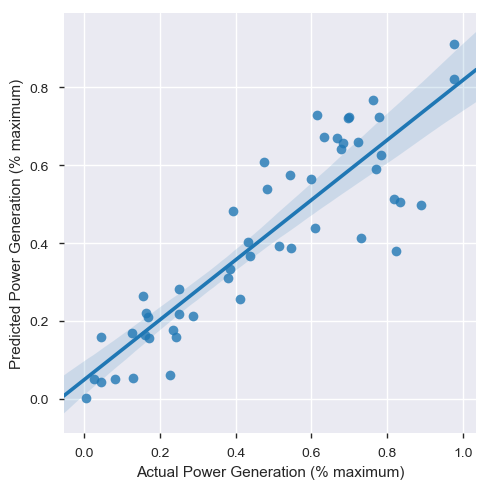

In [219]:
# predict cummulative (proportional to mean) daily hour output
# using week-ahead predictions model (168 hours ahead of time)
means = np.empty([0,4])
for i in range(50):
    tmp = np.array(np.mean(resultsdf.iloc[i*24:(i+1)*24,:]))
    tmp = tmp.reshape(1,-1)
    means = np.append(means, tmp, axis=0)

means_df = pd.DataFrame(data=means, columns = ['mean_time','mean_actual','mean_pred','mean_naiive_pred'])
weeks = np.linspace(0,len(means_df),len(means_df))
g = sns.lmplot(x="mean_actual", y="mean_pred", data=means_df)
g.set_axis_labels("Actual Power Generation (% maximum)", "Predicted Power Generation (% maximum)");

### Conclusions and future directions:
 - 7-day forcast provides accurate, if mildly conservative under-estimation, of power output
 - Using this proof-of-concept, we could develop station-specific models to predict wind energy output up to at least a week in advance
 - These long-term predictions would be extremely useful for making business decisions such as when to schedule maintenance of wind turbines, how much energy to store in other renewable infrastructures (i.e. pumped hydro), and provide early notice when surplus energy is expected.
 - Further optimization to the LSTM optimization algorithm could be performed, but due to the success of these initial models were not pursued.